# ConvNet House Numbers 

- toc: true
- branch: master
- badges: true
- comments: true
- author: nshea3
- categories: [keras, cnn, deeplearning, neuralnets]

## Introduction

I recently encountered a problem at work where we could have made use of georeferenced, exterior images of single-family homes. 

![](https://upload.wikimedia.org/wikipedia/commons/2/2c/Tibbetts-Rumsey_House%2C_Ithaca_NY.jpg)

Basically like this. 

We immediately thought of Google Streetview and Zillow, but unfortunately both of those platforms have very restrictive use policies. We also considered using data from assessors' offices, but that's difficult to do at scale because of the huge variety of ways that these images are stored, to say nothing of the metadata attached to them. 

So we set out to find a single source of just *images*, no licensing or metadata to hold us back. [Mapillary](https://www.mapillary.com/) provides an open alternative of entirely crowdsourced photos shared from dashcams. Much better than the alternatives, but it leaves us with a different challenge: 
While we know what street we're on and roughly where we are, we don't know the camera parameters, so we can't precisely associate parts of the image with an address. We don't even have a particularly good idea of which direction the camera is pointed. 

The natural solution to this problem is to do what humans did before GPS - look at road signs and house numbers! The address is literally painted all over the structure! We just have to segment it and extract it, ideally in an automated way. 


It's difficult to imagine a script that we could explicitly program that would handle all the varying fonts, varying camera angles, varying lighting conditions, varying photo qualities that we'll see in reality. In short, this is a classic use case for deep learning, so we'll assemble and train a quick convolutional neural network here! 

## The dataset

For this demonstration we'll use the [The Street View House Numbers (SVHN) Dataset](http://ufldl.stanford.edu/housenumbers/) from Stanford. This dataset contains a large number of labeled examples that we can use to train a convnet to label individual digits of a street number. 

In [1]:
import scipy.io
import tensorflow as tf
from matplotlib.pyplot import *
import numpy as np
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.python.ops.numpy_ops import np_config
np_config.enable_numpy_behavior()

mat = scipy.io.loadmat('/content/drive/MyDrive/DATA/train_32x32.mat')
mat_test = scipy.io.loadmat('/content/drive/MyDrive/DATA/test_32x32.mat')

This is what the 32x32 pixel digits look like: 

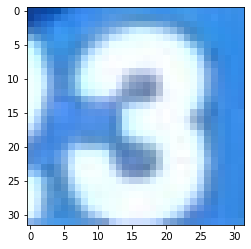

In [2]:
ax = imshow(mat["X"][:,:,:,3])

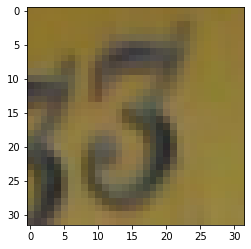

In [3]:
ax = imshow(mat["X"][:,:,:,115])

And the associated labels:

In [4]:
mat["y"][3]

array([3], dtype=uint8)

In [5]:
mat["y"][115]

array([3], dtype=uint8)

Even this toy example includes some of the challenges we listed above (varying fonts, varying camera angles, varying lighting conditions, varying photo qualities) - and others that we didn't discuss:

> Character level ground truth in an MNIST-like format. All digits have been resized to a fixed resolution of 32-by-32 pixels. The original character bounding boxes are extended in the appropriate dimension to become square windows, so that resizing them to 32-by-32 pixels does not introduce aspect ratio distortions. Nevertheless this preprocessing introduces some distracting digits to the sides of the digit of interest. 


## Preprocessing

We need to turn our array of RGB images into an array of greyscale images (it's definitely possible to do deep learning with RGB images, but it's a little more involved) And doing a little reshaping as well - need it in batch, pixel_x, pixel_y format.

We're using the 

In [6]:
x_train = tf.transpose(np.tensordot(mat["X"], [0.299, 0.587, 0.114], axes=([2], [0])), [2, 0, 1])
x_test = tf.transpose(np.tensordot(mat_test["X"], [0.299, 0.587, 0.114], axes=([2], [0])), [2, 0, 1])

x_train.shape

TensorShape([73257, 32, 32])

We're using the $v_{gray}(r,g,b) = 0.2989 * r + 0.5870 * g + 0.1140 * b$ formula to convert the (r,g,b) values into a grayscale value. 

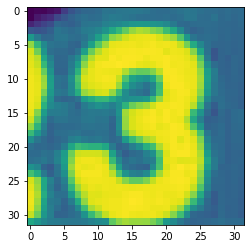

In [7]:
imshow(x_train[3,:,:])

New! with zero color! 

Now we move on to preparing the labels and further altering the shape of our tensor.

In [8]:
num_classes = len(np.unique(mat["y"])) + 1
print(f"Num classes: {num_classes}")

y_train = mat["y"].ravel()
y_test = mat_test["y"].ravel()

input_shape = (32, 32, 1)

def scale_and_expand(x_):
  return np.expand_dims((x_.astype("float32") / 255), -1)


x_train, x_test = (scale_and_expand(x) for x in (x_train, x_test))

print("x_train shape:", x_train.shape)
print(x_train.shape[0], "train samples")
print(x_test.shape[0], "test samples")

# convert class vectors to binary class matrices
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

Num classes: 11
x_train shape: (73257, 32, 32, 1)
73257 train samples
26032 test samples


## Model Topology

This is a simple ConvNet architecture (borrowed from [here](https://keras.io/examples/vision/mnist_convnet/) in the keras docs, credit to François Chollet)

In [9]:
model = keras.Sequential(
    [
        keras.Input(shape=input_shape),
        layers.Conv2D(32, kernel_size=(3, 3), activation="relu"),
        layers.MaxPooling2D(pool_size=(2, 2)),
        layers.Conv2D(64, kernel_size=(3, 3), activation="relu"),
        layers.MaxPooling2D(pool_size=(2, 2)),
        layers.Flatten(),
        layers.Dropout(0.5),
        layers.Dense(num_classes, activation="softmax"),
    ]
)

model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 30, 30, 32)        320       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 15, 15, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 13, 13, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 6, 6, 64)         0         
 2D)                                                             
                                                                 
 flatten (Flatten)           (None, 2304)              0         
                                                                 
 dropout (Dropout)           (None, 2304)              0

## Parameters and Training

In [10]:
batch_size = 128
epochs = 15

model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])

model.fit(x_train, y_train, batch_size=batch_size, epochs=epochs, validation_split=0.1)


Epoch 1/15
516/516 [==============================] - 101s 195ms/step - loss: 1.5204 - accuracy: 0.5037 - val_loss: 0.7716 - val_accuracy: 0.7935
Epoch 2/15
516/516 [==============================] - 87s 168ms/step - loss: 0.8102 - accuracy: 0.7637 - val_loss: 0.6294 - val_accuracy: 0.8354
Epoch 3/15
516/516 [==============================] - 77s 150ms/step - loss: 0.7143 - accuracy: 0.7977 - val_loss: 0.5900 - val_accuracy: 0.8460
Epoch 4/15
516/516 [==============================] - 89s 173ms/step - loss: 0.6613 - accuracy: 0.8141 - val_loss: 0.5400 - val_accuracy: 0.8598
Epoch 5/15
516/516 [==============================] - 88s 170ms/step - loss: 0.6289 - accuracy: 0.8232 - val_loss: 0.5257 - val_accuracy: 0.8597
Epoch 6/15
516/516 [==============================] - 83s 161ms/step - loss: 0.6051 - accuracy: 0.8284 - val_loss: 0.5008 - val_accuracy: 0.8677
Epoch 7/15
516/516 [==============================] - 80s 155ms/step - loss: 0.5827 - accuracy: 0.8354 - val_loss: 0.4865 - val_a

Looking at the train/validation scores in the diagnostic output, I always have to remind myself that dropout means that validation accuracy will often be **higher** than training accuracy! Otherwise quite happy with the convergence of our model. Let's see how it does on a held-out test set: 

In [11]:
score = model.evaluate(x_test, y_test, verbose=0)
print("Test loss:", score[0])
print("Test accuracy:", score[1])

Test loss: 0.4587405323982239
Test accuracy: 0.8741933107376099


Not too bad for a first pass! 

Sources: 

- [Higher validation accuracy, than training accurracy using Tensorflow and Keras](https://stackoverflow.com/questions/43979449/higher-validation-accuracy-than-training-accurracy-using-tensorflow-and-keras)

- [CS231n Convolutional Neural Networks for Visual Recognition: Lecture 3, Learning](https://cs231n.github.io/neural-networks-3/)

- [The Street View House Numbers (SVHN) Dataset](http://ufldl.stanford.edu/housenumbers/)

- [Simple MNIST convnet](https://keras.io/examples/vision/mnist_convnet/)
